In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,20)

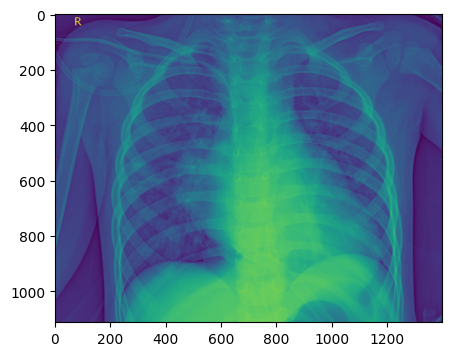

In [28]:
from glob import glob #retriving an array of files in directories
path_train = "/home/chirag/medical_classification_project/Data/train"
img = glob(path_train+"/PNEUMONIA/*.jpeg")
# print(img)
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

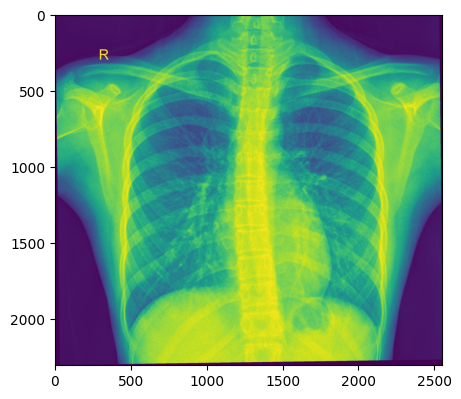

In [29]:
img = glob(path_train+"/NORMAL/*.jpeg")
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization

In [31]:
img_size=(150,150)
batch_size=25
traingen=ImageDataGenerator(
    rescale=1/255.,
    rotation_range=50,
    brightness_range=[0.2,1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.)

In [32]:
traindata=traingen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/train',
     target_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    
)

testdata=testgen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/test',
    shuffle=False,batch_size=batch_size,
    target_size=img_size,
    class_mode="binary",
    
)
valdata=valgen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/val',
    shuffle=False,
    batch_size=batch_size,
    target_size=img_size,
    class_mode="binary",
    
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [33]:
df=pd.DataFrame(traindata.classes)
df.value_counts()#0 for normal and 1 for pnuemonia

0
1    3875
0    1341
Name: count, dtype: int64

In [34]:
df=pd.DataFrame(testdata.classes)
df.value_counts()

0
1    390
0    234
Name: count, dtype: int64

In [35]:
df=pd.DataFrame(valdata.classes)
df.value_counts()

0
0    8
1    8
Name: count, dtype: int64

Since we can see that there is discrepency between the normal and pnumonia data we only apply augumentation on normal 

In [16]:
import os
import random
import shutil

# Paths to original folders
normal_dir = '/home/chirag/medical_classification_project/Data/train/NORMAL'
pneumonia_dir = '/home/chirag/medical_classification_project/Data/train/PNEUMONIA'

# Paths for the balanced dataset
balanced_train_dir = '/home/chirag/medical_classification_project/Data/balanced_train'
balanced_normal_dir = os.path.join(balanced_train_dir, 'NORMAL')
balanced_pneumonia_dir = os.path.join(balanced_train_dir, 'PNEUMONIA')

# Create balanced directories if they don't exist
os.makedirs(balanced_normal_dir, exist_ok=True)
os.makedirs(balanced_pneumonia_dir, exist_ok=True)

# Function to randomly sample images
def create_balanced_subset(src_dir, dest_dir, sample_size):
    all_images = os.listdir(src_dir)
    random.shuffle(all_images)
    selected_images = all_images[:sample_size]

    for img in selected_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(dest_dir, img))

# Sample 1300 images from each class
create_balanced_subset(normal_dir, balanced_normal_dir, 1300)
create_balanced_subset(pneumonia_dir, balanced_pneumonia_dir, 1300)

print(f"Balanced dataset created with 1300 images each for NORMAL and PNEUMONIA.")


Balanced dataset created with 1300 images each for NORMAL and PNEUMONIA.


In [36]:
traindata = traingen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/balanced_train',  # New balanced directory
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    
)

testdata = testgen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/test',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    
)

valdata = valgen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/val',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    
)


Found 2600 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [37]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(2,2),input_shape=(150,150,3),activation='relu',padding='same',strides=1))
model.add(MaxPooling2D())

model.add(Conv2D(64,(2,2),strides=2,activation="relu",padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(128,(2,2),strides=1,activation="relu",padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dense(1,activation='sigmoid'))

/home/chirag/medical_classification_project/medical_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 150, 150, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 38, 38, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 19, 19, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,368,929 (5.22 MB)

 Trainable params: 1,368,929 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= "model_cnn.keras"
early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)

In [41]:
history=model.fit(traindata,validation_data=valdata,epochs=50,callbacks=[checkpoint,early_stop])

/home/chirag/medical_classification_project/medical_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1739993392.129328   29583 service.cc:148] XLA service 0x78a034007460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739993392.129355   29583 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-02-20 00:59:52.153809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739993392.303043   29583 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/104 ━━━━━━━━━━━━━━━━━━━━ 4:54 3s/step - accuracy: 0.6000 - loss: 0.6885

I0000 00:00:1739993393.913732   29583 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5721 - loss: 0.6842
Epoch 1: val_loss improved from inf to 0.62065, saving model to model_cnn.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 211ms/step - accuracy: 0.5726 - loss: 0.6841 - val_accuracy: 0.6250 - val_loss: 0.6207
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7502 - loss: 0.5602
Epoch 2: val_loss improved from 0.62065 to 0.58091, saving model to model_cnn.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.7506 - loss: 0.5597 - val_accuracy: 0.6875 - val_loss: 0.5809
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8507 - loss: 0.4116
Epoch 3: val_loss did not improve from 0.58091
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.8508 - loss: 0.4115 - val_accuracy: 0.6875 - val_loss: 0.5926
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8688 - loss: 0.3564
Epoch 4: val_loss did not improve from 0.58091
104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/st

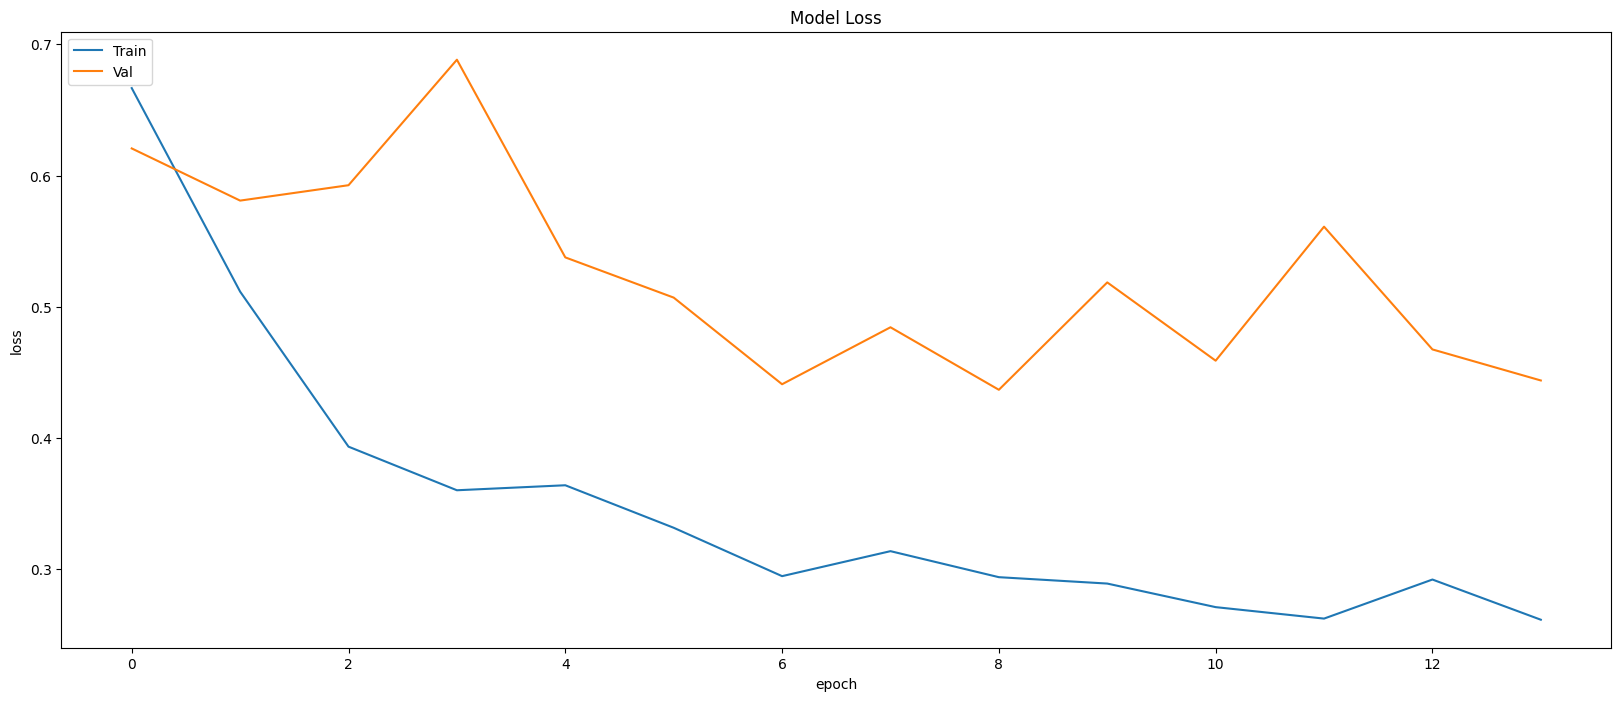

In [42]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


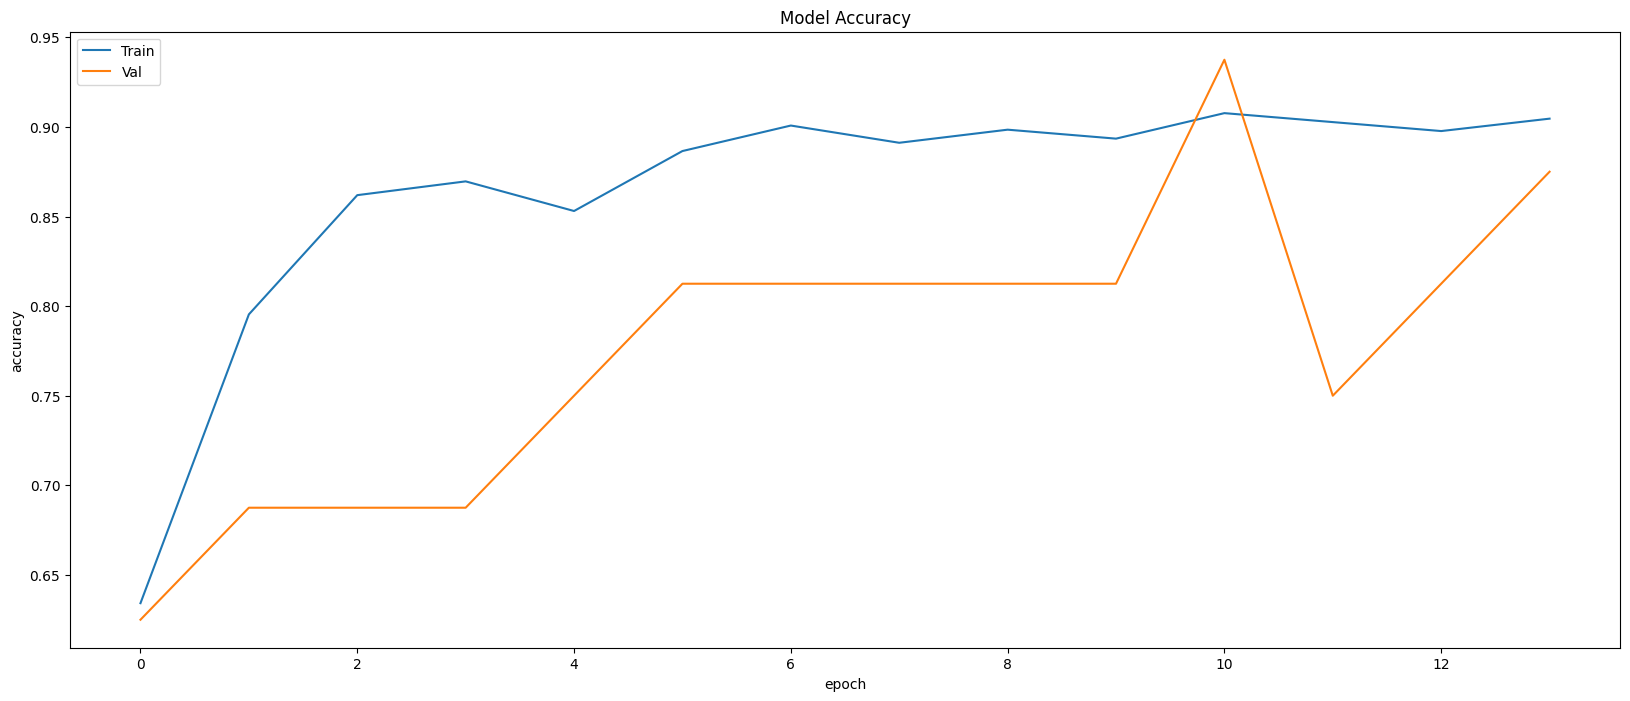

In [43]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Checking model performance for test data

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


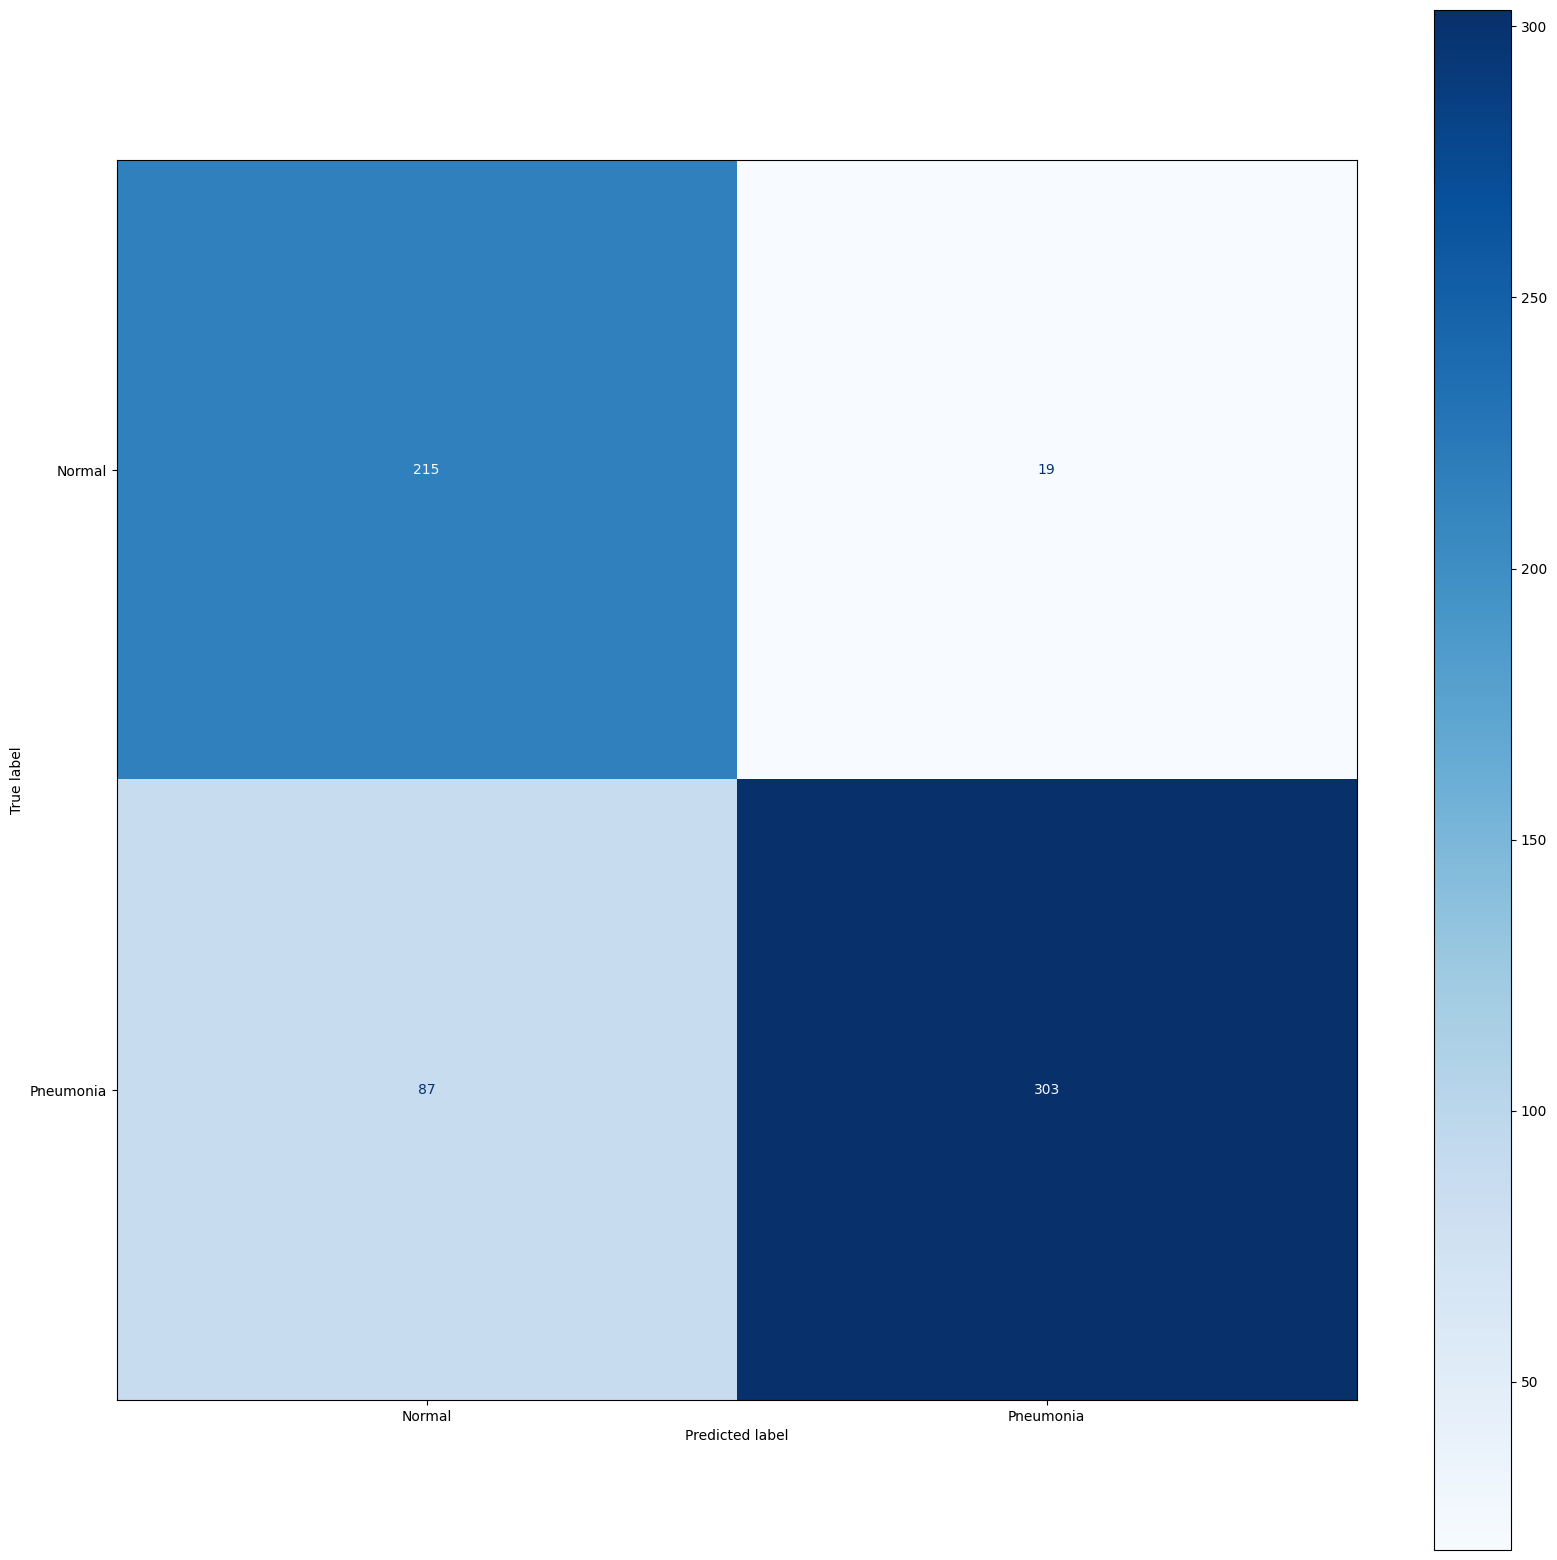

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from the test generator
true_labels = testdata.classes  # True class labels

# Get model predictions
predictions = model.predict(testdata)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [45]:
test_loss, test_accuracy = model.evaluate(testdata)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8867 - loss: 0.3228
Test Loss: 0.4874206483364105
Test Accuracy: 0.8301281929016113


In [46]:
from sklearn.metrics import classification_report
print('classification report: ')
print(classification_report(true_labels,predicted_labels))

classification report: 
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       234
           1       0.94      0.78      0.85       390

    accuracy                           0.83       624
   macro avg       0.83      0.85      0.83       624
weighted avg       0.86      0.83      0.83       624



In [47]:
# Get predicted probabilities for the positive class (Pneumonia)
y_pred_prob = model.predict(testdata)

if y_pred_prob.shape[1] > 1:  
    y_pred_prob = y_pred_prob[:, 1]  # Take the probability for class 1 (Pneumonia)
else:
    y_pred_prob = y_pred_prob.flatten()  # If binary, the array may already be 1D


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


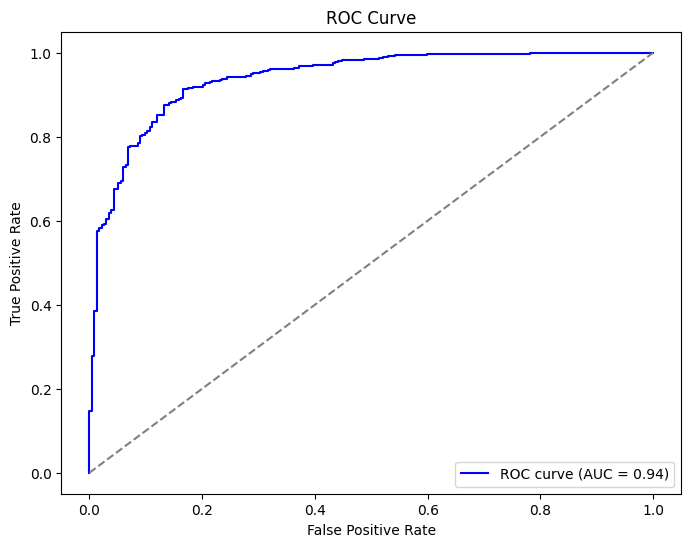

In [48]:
#ROC Curve
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

AUC is 0.94 which is considered excellent 